In [1]:
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import urllib.request
import random
import os
import urllib
import tarfile
import pickle
import utils
from utils import buildNetwork, load_cifar,download_cifar
from scipy.ndimage.filters import gaussian_filter

# URL for the data-set on the internet.
data_path = "data/CIFAR-10/"
data_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

In [2]:
# Let's start a Session
sess = tf.Session()

## Download CIFAR-10 (only needs to be run once)

In [3]:
download_cifar(data_path, data_url)

Download finished. Extracting files.
Done.


## Loading CIFAR-10 into memory

In [3]:
train_samples, train_labels, val_samples, val_labels = load_cifar(data_path)

In [4]:
DATA_AUGMENTATION=False
#set to true, enables a simple data augmentation procedure,
#Apologies though, my resources are limited, couldn't train for val accuracy higher than 71%
if DATA_AUGMENTATION:
    augmentedSamples=[]
    augmentedLabels=[]
    for i in range(train_samples.shape[0]):
        augmentedSamples.append(train_samples[i,:,:,:])
        augmentedSamples.append(np.flipud(train_samples[i,:,:,:]))
        augmentedSamples.append(np.fliplr(train_samples[i,:,:,:]))
        augmentedSamples.append(np.fliplr(np.flipud(train_samples[i,:,:,:])))
        augmentedSamples.append(gaussian_filter(train_samples[i,:,:,:], sigma=0.5))
        augmentedLabels.append(train_labels[i])
        augmentedLabels.append(train_labels[i])
        augmentedLabels.append(train_labels[i])
        augmentedLabels.append(train_labels[i])
        augmentedLabels.append(train_labels[i])
    
    train_samples = np.asarray(augmentedSamples)
    train_labels = np.asarray(augmentedLabels)


## Task: Use matplotlib to plot 5 random *training* samples and print the corresponding class label

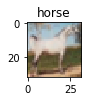

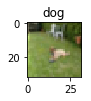

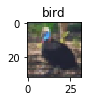

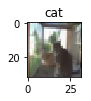

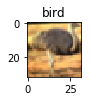

In [5]:
label_to_name = ['airplane', 'automobile', 'bird', 'cat', 'deer' , 'dog', 'frog', 'horse', 'ship', 'truck']
indeces = random.sample(range(0, train_samples.shape[0]), 5)
# TODO plot 5 training samples
for index in indeces:
    plt.figure(figsize=(1,1))
    plt.title(label_to_name[train_labels[index]])
    plt.imshow(train_samples[index])




## Building Tensorflow Graph

In [6]:
HEIGHT = 32
WIDTH = 32
CHANNELS = 3
NUM_CLASSES = 10

# You can also modify these hyper-parameters (batch_size, epochs)
# e.g. Add more epochs, if not converged. Reduce batch_size if too big for your GPU memory
batch_size = 100
num_train_epochs = 30
steps_per_epoch = int( train_samples.shape[0] / batch_size)

In [7]:
# TODO define placeholders for the inputs and their labels (hint: what is their type, shape?)

inputs = tf.placeholder(tf.float32,name='input',shape=[batch_size,WIDTH,HEIGHT,CHANNELS])
labels = tf.placeholder(tf.int32,name='output',shape=[batch_size])
keep_prob = tf.placeholder(tf.float32) #for dropout
logits = buildNetwork(inputs, batch_size,keep_prob=keep_prob)

## Task: Build the Loss. Add weight regularization.

In [8]:
# TODO add an appropriate cross entropy loss function
loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels,logits=logits,name='crossEntropy')

# TODO use reduce_mean to combine the single loss values from all the different input samples
meanLoss= tf.reduce_mean(loss)

# TODO add L2 regularization
alpha=0.01
tvars =tf.trainable_variables()
l2_reg = tf.reduce_sum([tf.nn.l2_loss(var) for var in tvars])
loss = meanLoss+alpha*l2_reg
# hint: use tf.trainable_variables() and tf.nn.l2_loss(var)


In [9]:
# Compute accuracy as an evaluation metric
predictions = tf.to_int32(tf.argmax(logits, axis=1))
correct_mask = tf.to_float(tf.equal(predictions, labels))
accuracy = tf.reduce_mean(correct_mask)


## Task: Define Learning Rate, Optimizer and Training Operation

In [10]:
# TODO define the learning rate
learningRate = 0.001
# TODO define the optimizer (experiment with different options)
opt = tf.train.AdamOptimizer( learning_rate=learningRate,
    beta1=0.9,
    beta2=0.999,
    epsilon=1e-08,
    use_locking=False,
    name='Adam')# TODO build the corresponding training operation
opt_op = opt.minimize(loss)

In [11]:
# Define summary operations. Note, that the names may vary depending on how you defined variables!

train_summaries = [
  tf.summary.scalar('train_loss', loss),
  tf.summary.scalar('train_accuracy', accuracy)
]
train_summary_op = tf.summary.merge(train_summaries)


val_accuracy = tf.placeholder(tf.float32)

val_summary_op = tf.summary.scalar('val_accuracy', val_accuracy)

# Define a single summary writer, which will take care of writing
# our summary representations to disk.
writer = tf.summary.FileWriter('log')

## Task: Initialize the variables

In [12]:
# TODO use the variables initializer to build the operation and run it in the current session (named sess)
model = tf.global_variables_initializer()
sess.run(model)

##  Task: Train your network. Display the progress. 

In [16]:
def gen_data(source):
    indices =list(range(len(source[0])))
    random.shuffle(indices)

    while True:
    #indices = range(len(source[0]))
    #random.shuffle(indices)
        for i in indices:
        
            image = source[0][i]
            #label=np.zeros(NUM_CLASSES)
            label=source[1][i]
            yield image, label


def gen_data_batch(source,batchSize):
    data_gen = gen_data(source)
    #for i in range(numberOfBatches):
    while(True):
        images_batch = []
        labels_batch = []
        for _ in range(batchSize):
            img, label = next(data_gen)
            images_batch.append(img)
            #plt.figure(figsize=(1.5,1.5))
            #plt.title(label_to_name[label])
            #plt.imshow(img)
            labels_batch.append(label)
        #print("batch served!")
        yield np.array(images_batch),np.asarray(labels_batch)



In [17]:
# indicators on how often to create a summary
num_steps_per_train_summary = 5  

# TODO run num_train_steps iterations on the training samples each of batchsize 50
#samples_indices = list(range(train_samples.shape[0]))
for epoch in range(num_train_epochs):
    #print("epoch")
    print('epoch #'+str(epoch))
    
    
    # TODO randomly shuffle training samples
    #random.shuffle(samples_indices)
    for iteration in range(steps_per_epoch):
        #print('iter')
        #print(iter)
        # TODO read the batch and execute one iteration of the graph 
        Xs,Ys = next(gen_data_batch([train_samples,train_labels],batch_size))
        #print('\r')
    #print(Ys)    
        l,summary, _  =  sess.run([loss, train_summary_op, opt_op], feed_dict={inputs: Xs, labels: Ys,keep_prob:1.})
    #print(epoch)
    #print(summary)
        print('\rEpoch: '+str(epoch)+'_Iteration: '+str(iteration)+' Loss: '+str(l))
    
    
        # TODO every num_steps_per_train_summary iterations: 
        #     save the current training status (loss and accuracy) to tensorboard
    if epoch % num_steps_per_train_summary==0:
            writer.add_summary(summary, global_step=epoch)
            
    
    #writer.add_summary(summary, global_step=epoch)
    # TODO every epoch: 
    validation_steps = int(val_samples.shape[0]/batch_size)
    acc=0
    for valStep in range(validation_steps):
        Xs,Ys=next(gen_data_batch([val_samples,val_labels],batch_size))
        res=  sess.run([ accuracy], feed_dict={inputs: Xs, labels: Ys,keep_prob:1.})
        print(res)
        acc+=res[0]
        print('val accuracy so far: '+str(acc))
        summary=sess.run([ val_summary_op], feed_dict={val_accuracy: acc})
        writer.add_summary(summary[0], global_step=epoch)
    #     save the current validation accuracy to tensorboard
    # Note: we are interested in the accuracy over the *entire* validation set, not just the current batch



epoch #0
Epoch: 0_Iteration: 0 Loss: 7.87409
Epoch: 0_Iteration: 1 Loss: 7.67343
Epoch: 0_Iteration: 2 Loss: 7.49884
Epoch: 0_Iteration: 3 Loss: 7.31474
Epoch: 0_Iteration: 4 Loss: 7.14236


KeyboardInterrupt: 

## Task: Save the trained model into checkpoints

In [ ]:
# TODO use tf.train.Saver to save the trained model as checkpoints/model.ckpt
saver = tf.train.Saver()
saver.save(sess, 'checkpoints/model.ckpt')




## Bonus Exercise: Use different methods to further improve your accuracy. 
### e.g. De-mean input, use data Augmentation (flip image, rotate image, add noise), add dropout ... 

In [ ]:
# Hint: tf.nn.dropout, tf.image.flip_left_right, .... 
# Note that this should only be applied during training and not during testing!! 
# Hint: Use an extra tf.placeholder to indicate if training.


#please check the DATA_AUGMENTATION  and the keep_prob, also in utils.py the modification to buildnetwork